# Machine Learning Project Report 2, Sage Edwards

### Import Modules and Libraries

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

## Generative Adversarial Networks

### Learning Parameters

Batch size determins the number of training samples to work with.

Epoch(s) is the number of training iterations.



In [3]:
batch_size = 512
epochs = 301
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

### Dataset Preperation

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), # convert images to tensors
    transforms.Normalize((0.5,),(0.5,)), # normalize them
])

to_pil_image = transforms.ToPILImage() # convert to PIL image format

# Download and define the MNIST dataset
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
# Define the data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

### Generator Neural Network

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        # Sequential container to build the neural network
        self.main = nn.Sequential(
            # Four linear layers with three LearkyReLu activations and the last layer being a Tanh
            
            # Initial Layer
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            
            # Second Layer
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            
            # Third Layer
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            
            # Final Layer
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    # Pass the batch through the neural network layers
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

### Discriminator Neural Network

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

### Initialize the Neural Networks and Define the Optimizers

In [8]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

print('##### GENERATOR #####')
print(generator)
print('######################')

print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function
criterion = nn.BCELoss()

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

### Defining Utility Functions

In [9]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

### Function for Training the Discriminator

In [10]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

### Function to Train the Generator

In [11]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

### Training the GAN

In [12]:
# create the noise vector
noise = create_noise(sample_size, nz)

generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

### The Training Loop

118it [00:06, 17.51it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.37it/s]

Epoch 0 of 301
Generator loss: 1.28361320, Discriminator loss: 1.02001798


118it [00:06, 17.42it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.07it/s]

Epoch 1 of 301
Generator loss: 1.54967308, Discriminator loss: 1.16607308


118it [00:06, 17.67it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.18it/s]

Epoch 2 of 301
Generator loss: 4.45187616, Discriminator loss: 0.85784709


118it [00:06, 17.77it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.24it/s]

Epoch 3 of 301
Generator loss: 7.60040569, Discriminator loss: 0.31383425


118it [00:06, 17.78it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.33it/s]

Epoch 4 of 301
Generator loss: 7.11803913, Discriminator loss: 0.57338446


118it [00:06, 17.83it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.25it/s]

Epoch 5 of 301
Generator loss: 3.98207355, Discriminator loss: 0.73629177


118it [00:06, 17.72it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.10it/s]

Epoch 6 of 301
Generator loss: 3.82554650, Discriminator loss: 0.82599515


118it [00:06, 17.75it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.07it/s]

Epoch 7 of 301
Generator loss: 2.36166334, Discriminator loss: 0.95056349


118it [00:06, 17.70it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.49it/s]

Epoch 8 of 301
Generator loss: 2.66235042, Discriminator loss: 0.87299359


118it [00:06, 17.70it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.83it/s]

Epoch 9 of 301
Generator loss: 2.77399755, Discriminator loss: 0.80052072


118it [00:06, 17.66it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.38it/s]

Epoch 10 of 301
Generator loss: 2.40780234, Discriminator loss: 1.08374774


118it [00:06, 17.92it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.87it/s]

Epoch 11 of 301
Generator loss: 2.18576121, Discriminator loss: 0.94956273


118it [00:06, 17.53it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.68it/s]

Epoch 12 of 301
Generator loss: 1.11273015, Discriminator loss: 1.22711623


118it [00:06, 17.40it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.32it/s]

Epoch 13 of 301
Generator loss: 2.15039921, Discriminator loss: 0.88954836


118it [00:06, 17.81it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.35it/s]

Epoch 14 of 301
Generator loss: 2.53984356, Discriminator loss: 0.91532516


118it [00:06, 17.91it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.46it/s]

Epoch 15 of 301
Generator loss: 2.37438202, Discriminator loss: 0.89721274


118it [00:06, 17.96it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.32it/s]

Epoch 16 of 301
Generator loss: 2.96369648, Discriminator loss: 0.91840988


118it [00:06, 18.10it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.59it/s]

Epoch 17 of 301
Generator loss: 4.98488235, Discriminator loss: 0.71961051


118it [00:06, 17.41it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.33it/s]

Epoch 18 of 301
Generator loss: 2.87766695, Discriminator loss: 0.53821689


118it [00:06, 17.69it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.15it/s]

Epoch 19 of 301
Generator loss: 3.36603379, Discriminator loss: 0.52891296


118it [00:06, 17.58it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.04it/s]

Epoch 20 of 301
Generator loss: 3.25770211, Discriminator loss: 0.52912438


118it [00:06, 17.36it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.41it/s]

Epoch 21 of 301
Generator loss: 3.10699224, Discriminator loss: 0.46810636


118it [00:06, 17.81it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.71it/s]

Epoch 22 of 301
Generator loss: 3.96219993, Discriminator loss: 0.32247916


118it [00:06, 17.64it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.81it/s]

Epoch 23 of 301
Generator loss: 3.93381548, Discriminator loss: 0.27890888


118it [00:06, 17.38it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.72it/s]

Epoch 24 of 301
Generator loss: 3.59934378, Discriminator loss: 0.42074957


118it [00:06, 17.80it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.53it/s]

Epoch 25 of 301
Generator loss: 3.51004004, Discriminator loss: 0.43335351


118it [00:06, 17.78it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.21it/s]

Epoch 26 of 301
Generator loss: 3.49333096, Discriminator loss: 0.35370037


118it [00:06, 17.71it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.14it/s]

Epoch 27 of 301
Generator loss: 3.41299748, Discriminator loss: 0.44647017


118it [00:06, 17.43it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.99it/s]

Epoch 28 of 301
Generator loss: 3.37608242, Discriminator loss: 0.40414318


118it [00:06, 17.75it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.02it/s]

Epoch 29 of 301
Generator loss: 3.62211776, Discriminator loss: 0.38006791


118it [00:06, 17.59it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.03it/s]

Epoch 30 of 301
Generator loss: 3.77922320, Discriminator loss: 0.31085321


118it [00:06, 17.56it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.21it/s]

Epoch 31 of 301
Generator loss: 3.47862363, Discriminator loss: 0.38566321


118it [00:06, 17.96it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.47it/s]

Epoch 32 of 301
Generator loss: 3.64729524, Discriminator loss: 0.37158465


118it [00:06, 17.85it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.90it/s]

Epoch 33 of 301
Generator loss: 3.23877120, Discriminator loss: 0.41592696


118it [00:06, 17.47it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.39it/s]

Epoch 34 of 301
Generator loss: 3.57168698, Discriminator loss: 0.41331503


118it [00:06, 17.46it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.02it/s]

Epoch 35 of 301
Generator loss: 3.20740151, Discriminator loss: 0.41763431


118it [00:06, 17.47it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.34it/s]

Epoch 36 of 301
Generator loss: 3.38295150, Discriminator loss: 0.39772201


118it [00:06, 17.61it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.49it/s]

Epoch 37 of 301
Generator loss: 3.51776123, Discriminator loss: 0.39567068


118it [00:06, 17.62it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.85it/s]

Epoch 38 of 301
Generator loss: 3.21668172, Discriminator loss: 0.45494771


118it [00:06, 17.39it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.00it/s]

Epoch 39 of 301
Generator loss: 3.46089029, Discriminator loss: 0.43438184


118it [00:06, 17.39it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.30it/s]

Epoch 40 of 301
Generator loss: 3.37042737, Discriminator loss: 0.41548401


118it [00:06, 17.52it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.16it/s]

Epoch 41 of 301
Generator loss: 3.41589546, Discriminator loss: 0.42372358


118it [00:06, 17.50it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.07it/s]

Epoch 42 of 301
Generator loss: 3.26606464, Discriminator loss: 0.45641577


118it [00:06, 17.28it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.79it/s]

Epoch 43 of 301
Generator loss: 3.39150929, Discriminator loss: 0.42534649


118it [00:06, 17.44it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.07it/s]

Epoch 44 of 301
Generator loss: 3.15135098, Discriminator loss: 0.42849293


118it [00:06, 17.66it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.33it/s]

Epoch 45 of 301
Generator loss: 3.35510468, Discriminator loss: 0.40973896


118it [00:06, 17.42it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.08it/s]

Epoch 46 of 301
Generator loss: 3.09069467, Discriminator loss: 0.45340943


118it [00:06, 17.32it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.01it/s]

Epoch 47 of 301
Generator loss: 3.20235682, Discriminator loss: 0.45892653


118it [00:06, 17.42it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.86it/s]

Epoch 48 of 301
Generator loss: 3.14528251, Discriminator loss: 0.45250443


118it [00:06, 17.26it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.97it/s]

Epoch 49 of 301
Generator loss: 2.94852757, Discriminator loss: 0.50281662


118it [00:06, 17.29it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.03it/s]

Epoch 50 of 301
Generator loss: 2.81985879, Discriminator loss: 0.58834589


118it [00:06, 17.36it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.49it/s]

Epoch 51 of 301
Generator loss: 2.94646001, Discriminator loss: 0.47908521


118it [00:06, 17.49it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.86it/s]

Epoch 52 of 301
Generator loss: 3.02794647, Discriminator loss: 0.50808299


118it [00:06, 17.46it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.05it/s]

Epoch 53 of 301
Generator loss: 2.98956728, Discriminator loss: 0.54070050


118it [00:06, 17.58it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.99it/s]

Epoch 54 of 301
Generator loss: 2.85566640, Discriminator loss: 0.52927470


118it [00:06, 17.62it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.39it/s]

Epoch 55 of 301
Generator loss: 2.97412801, Discriminator loss: 0.50801671


118it [00:06, 17.81it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.22it/s]

Epoch 56 of 301
Generator loss: 2.97899723, Discriminator loss: 0.55998480


118it [00:06, 17.68it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.83it/s]

Epoch 57 of 301
Generator loss: 2.64962173, Discriminator loss: 0.61831594


118it [00:06, 17.52it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.83it/s]

Epoch 58 of 301
Generator loss: 2.65208912, Discriminator loss: 0.58308911


118it [00:06, 17.28it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.72it/s]

Epoch 59 of 301
Generator loss: 2.58266950, Discriminator loss: 0.59195399


118it [00:06, 17.67it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.43it/s]

Epoch 60 of 301
Generator loss: 2.53137231, Discriminator loss: 0.59076065


118it [00:06, 17.63it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.34it/s]

Epoch 61 of 301
Generator loss: 2.66908836, Discriminator loss: 0.56204802


118it [00:06, 17.71it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.67it/s]

Epoch 62 of 301
Generator loss: 2.58667421, Discriminator loss: 0.57480174


118it [00:06, 17.38it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.03it/s]

Epoch 63 of 301
Generator loss: 2.72935081, Discriminator loss: 0.56820583


118it [00:06, 17.42it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.68it/s]

Epoch 64 of 301
Generator loss: 2.62612820, Discriminator loss: 0.59471029


118it [00:06, 17.30it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

Epoch 65 of 301
Generator loss: 2.57393241, Discriminator loss: 0.61875278


118it [00:06, 17.30it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.62it/s]

Epoch 66 of 301
Generator loss: 2.46353030, Discriminator loss: 0.63123119


118it [00:06, 17.42it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.04it/s]

Epoch 67 of 301
Generator loss: 2.43040752, Discriminator loss: 0.64738131


118it [00:06, 17.34it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.95it/s]

Epoch 68 of 301
Generator loss: 2.50111985, Discriminator loss: 0.61086053


118it [00:06, 17.34it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.75it/s]

Epoch 69 of 301
Generator loss: 2.46233153, Discriminator loss: 0.63380122


118it [00:06, 17.28it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.86it/s]

Epoch 70 of 301
Generator loss: 2.36652803, Discriminator loss: 0.65496665


118it [00:06, 17.47it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.40it/s]

Epoch 71 of 301
Generator loss: 2.40034795, Discriminator loss: 0.64323163


118it [00:06, 17.78it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.36it/s]

Epoch 72 of 301
Generator loss: 2.39446688, Discriminator loss: 0.63699722


118it [00:06, 17.87it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.22it/s]

Epoch 73 of 301
Generator loss: 2.35976243, Discriminator loss: 0.65425479


118it [00:06, 17.52it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.87it/s]

Epoch 74 of 301
Generator loss: 2.27176952, Discriminator loss: 0.70305359


118it [00:06, 17.36it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.84it/s]

Epoch 75 of 301
Generator loss: 2.21089864, Discriminator loss: 0.72276258


118it [00:06, 17.35it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.98it/s]

Epoch 76 of 301
Generator loss: 2.13939786, Discriminator loss: 0.74568540


118it [00:06, 17.19it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.69it/s]

Epoch 77 of 301
Generator loss: 2.22756100, Discriminator loss: 0.69191802


118it [00:06, 17.24it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.23it/s]

Epoch 78 of 301
Generator loss: 2.25867152, Discriminator loss: 0.67384094


118it [00:06, 17.70it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.15it/s]

Epoch 79 of 301
Generator loss: 2.17704129, Discriminator loss: 0.69498795


118it [00:06, 17.53it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.20it/s]

Epoch 80 of 301
Generator loss: 2.29417419, Discriminator loss: 0.67279667


118it [00:06, 17.33it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.32it/s]

Epoch 81 of 301
Generator loss: 2.28286290, Discriminator loss: 0.70772415


118it [00:06, 17.79it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.23it/s]

Epoch 82 of 301
Generator loss: 2.11417723, Discriminator loss: 0.71168405


118it [00:06, 17.51it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.11it/s]

Epoch 83 of 301
Generator loss: 2.12289691, Discriminator loss: 0.72084486


118it [00:06, 17.52it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.13it/s]

Epoch 84 of 301
Generator loss: 2.11438680, Discriminator loss: 0.71764797


118it [00:06, 17.47it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.21it/s]

Epoch 85 of 301
Generator loss: 2.12316847, Discriminator loss: 0.72395772


118it [00:06, 17.56it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.98it/s]

Epoch 86 of 301
Generator loss: 2.06876707, Discriminator loss: 0.77289408


118it [00:06, 17.48it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.43it/s]

Epoch 87 of 301
Generator loss: 2.17076159, Discriminator loss: 0.74344790


118it [00:06, 17.50it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.85it/s]

Epoch 88 of 301
Generator loss: 2.08192444, Discriminator loss: 0.72427124


118it [00:06, 17.48it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.99it/s]

Epoch 89 of 301
Generator loss: 2.07847309, Discriminator loss: 0.75857258


118it [00:06, 17.67it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.09it/s]

Epoch 90 of 301
Generator loss: 2.05450249, Discriminator loss: 0.75061131


118it [00:06, 17.41it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.82it/s]

Epoch 91 of 301
Generator loss: 2.06250429, Discriminator loss: 0.75088990


118it [00:06, 17.31it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.14it/s]

Epoch 92 of 301
Generator loss: 1.90861249, Discriminator loss: 0.82981610


118it [00:06, 17.58it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.38it/s]

Epoch 93 of 301
Generator loss: 1.91467607, Discriminator loss: 0.81630653


118it [00:06, 17.82it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.06it/s]

Epoch 94 of 301
Generator loss: 1.93480623, Discriminator loss: 0.80003983


118it [00:06, 17.64it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.15it/s]

Epoch 95 of 301
Generator loss: 2.00137639, Discriminator loss: 0.77453965


118it [00:06, 17.49it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.68it/s]

Epoch 96 of 301
Generator loss: 1.96869648, Discriminator loss: 0.77124673


118it [00:06, 17.28it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.88it/s]

Epoch 97 of 301
Generator loss: 2.02318430, Discriminator loss: 0.75125831


118it [00:06, 17.36it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.28it/s]

Epoch 98 of 301
Generator loss: 2.13758826, Discriminator loss: 0.72738940


118it [00:06, 17.61it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.23it/s]

Epoch 99 of 301
Generator loss: 2.14368272, Discriminator loss: 0.72716904


118it [00:06, 17.53it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.10it/s]

Epoch 100 of 301
Generator loss: 1.92586863, Discriminator loss: 0.81548584


118it [00:06, 17.38it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.72it/s]

Epoch 101 of 301
Generator loss: 1.88993263, Discriminator loss: 0.81897914


118it [00:06, 17.69it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.46it/s]

Epoch 102 of 301
Generator loss: 1.95191944, Discriminator loss: 0.78784990


118it [00:06, 17.57it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.95it/s]

Epoch 103 of 301
Generator loss: 2.00591326, Discriminator loss: 0.79469544


118it [00:06, 17.33it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.63it/s]

Epoch 104 of 301
Generator loss: 2.01465154, Discriminator loss: 0.79802197


118it [00:06, 17.29it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.09it/s]

Epoch 105 of 301
Generator loss: 1.86215842, Discriminator loss: 0.82035005


118it [00:06, 17.46it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.05it/s]

Epoch 106 of 301
Generator loss: 1.94541979, Discriminator loss: 0.79455149


118it [00:06, 17.50it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.23it/s]

Epoch 107 of 301
Generator loss: 1.86745298, Discriminator loss: 0.80224156


118it [00:06, 17.56it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.13it/s]

Epoch 108 of 301
Generator loss: 1.96774840, Discriminator loss: 0.81049746


118it [00:06, 17.63it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.13it/s]

Epoch 109 of 301
Generator loss: 1.84077811, Discriminator loss: 0.85650080


118it [00:06, 17.50it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.83it/s]

Epoch 110 of 301
Generator loss: 1.82562220, Discriminator loss: 0.85294992


118it [00:06, 17.51it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.07it/s]

Epoch 111 of 301
Generator loss: 1.80850184, Discriminator loss: 0.85253596


118it [00:06, 17.25it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.99it/s]

Epoch 112 of 301
Generator loss: 1.87529695, Discriminator loss: 0.81046194


118it [00:06, 17.28it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.88it/s]

Epoch 113 of 301
Generator loss: 1.90365326, Discriminator loss: 0.80768591


118it [00:06, 17.55it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.79it/s]

Epoch 114 of 301
Generator loss: 1.79113030, Discriminator loss: 0.84457982


118it [00:06, 17.27it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.05it/s]

Epoch 115 of 301
Generator loss: 1.85687041, Discriminator loss: 0.82356137


118it [00:06, 17.30it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.00it/s]

Epoch 116 of 301
Generator loss: 1.81408322, Discriminator loss: 0.84993899


118it [00:06, 17.64it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.84it/s]

Epoch 117 of 301
Generator loss: 1.86656475, Discriminator loss: 0.83464438


118it [00:06, 17.50it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.06it/s]

Epoch 118 of 301
Generator loss: 1.80638778, Discriminator loss: 0.84283340


118it [00:06, 17.26it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.23it/s]

Epoch 119 of 301
Generator loss: 1.85013723, Discriminator loss: 0.83053595


118it [00:06, 17.44it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.91it/s]

Epoch 120 of 301
Generator loss: 1.77683651, Discriminator loss: 0.85404581


118it [00:06, 17.35it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.10it/s]

Epoch 121 of 301
Generator loss: 1.72422457, Discriminator loss: 0.87329215


118it [00:06, 17.37it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.78it/s]

Epoch 122 of 301
Generator loss: 1.70554280, Discriminator loss: 0.89357585


118it [00:06, 17.40it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.24it/s]

Epoch 123 of 301
Generator loss: 1.73468578, Discriminator loss: 0.87329239


118it [00:06, 17.43it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.33it/s]

Epoch 124 of 301
Generator loss: 1.71378565, Discriminator loss: 0.88072848


118it [00:06, 17.20it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.11it/s]

Epoch 125 of 301
Generator loss: 1.72518516, Discriminator loss: 0.87299395


118it [00:06, 17.44it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.40it/s]

Epoch 126 of 301
Generator loss: 1.69587255, Discriminator loss: 0.87518275


118it [00:06, 17.30it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.13it/s]

Epoch 127 of 301
Generator loss: 1.65300906, Discriminator loss: 0.91702658


118it [00:06, 17.74it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.98it/s]

Epoch 128 of 301
Generator loss: 1.66500497, Discriminator loss: 0.91330093


118it [00:06, 17.71it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.46it/s]

Epoch 129 of 301
Generator loss: 1.62924516, Discriminator loss: 0.92205822


118it [00:06, 17.24it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.31it/s]

Epoch 130 of 301
Generator loss: 1.66233146, Discriminator loss: 0.92971337


118it [00:06, 17.31it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.03it/s]

Epoch 131 of 301
Generator loss: 1.66208756, Discriminator loss: 0.92153096


118it [00:06, 17.43it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.33it/s]

Epoch 132 of 301
Generator loss: 1.63936245, Discriminator loss: 0.90538007


118it [00:06, 17.50it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.01it/s]

Epoch 133 of 301
Generator loss: 1.66777778, Discriminator loss: 0.92529255


118it [00:06, 17.25it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.90it/s]

Epoch 134 of 301
Generator loss: 1.64572191, Discriminator loss: 0.92739749


118it [00:06, 17.31it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.11it/s]

Epoch 135 of 301
Generator loss: 1.60875666, Discriminator loss: 0.92686415


118it [00:06, 17.39it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.02it/s]

Epoch 136 of 301
Generator loss: 1.56788671, Discriminator loss: 0.92812252


118it [00:06, 17.51it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.01it/s]

Epoch 137 of 301
Generator loss: 1.59829247, Discriminator loss: 0.93357706


118it [00:06, 17.30it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.30it/s]

Epoch 138 of 301
Generator loss: 1.63159478, Discriminator loss: 0.91262650


118it [00:06, 17.51it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.02it/s]

Epoch 139 of 301
Generator loss: 1.65122926, Discriminator loss: 0.90941072


118it [00:06, 17.30it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.82it/s]

Epoch 140 of 301
Generator loss: 1.62399459, Discriminator loss: 0.92336637


118it [00:06, 17.14it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.66it/s]

Epoch 141 of 301
Generator loss: 1.60080743, Discriminator loss: 0.93355638


118it [00:06, 17.51it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.01it/s]

Epoch 142 of 301
Generator loss: 1.58916128, Discriminator loss: 0.94812191


118it [00:06, 17.76it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.87it/s]

Epoch 143 of 301
Generator loss: 1.58434975, Discriminator loss: 0.95132381


118it [00:06, 17.29it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.27it/s]

Epoch 144 of 301
Generator loss: 1.53850877, Discriminator loss: 0.94776630


118it [00:06, 17.74it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.33it/s]

Epoch 145 of 301
Generator loss: 1.58452129, Discriminator loss: 0.92994100


118it [00:06, 17.73it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.13it/s]

Epoch 146 of 301
Generator loss: 1.52199507, Discriminator loss: 0.95629650


118it [00:06, 17.13it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.12it/s]

Epoch 147 of 301
Generator loss: 1.58803439, Discriminator loss: 0.95653009


118it [00:06, 17.17it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.14it/s]

Epoch 148 of 301
Generator loss: 1.53974044, Discriminator loss: 0.96304423


118it [00:06, 17.38it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.65it/s]

Epoch 149 of 301
Generator loss: 1.50053489, Discriminator loss: 0.97410548


118it [00:06, 16.99it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.94it/s]

Epoch 150 of 301
Generator loss: 1.55457044, Discriminator loss: 0.96379173


118it [00:06, 17.06it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.03it/s]

Epoch 151 of 301
Generator loss: 1.44871449, Discriminator loss: 0.99473804


118it [00:06, 16.89it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.18it/s]

Epoch 152 of 301
Generator loss: 1.43477726, Discriminator loss: 0.99868739


118it [00:06, 17.30it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.98it/s]

Epoch 153 of 301
Generator loss: 1.46205556, Discriminator loss: 0.98967147


118it [00:06, 17.06it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.55it/s]

Epoch 154 of 301
Generator loss: 1.44376194, Discriminator loss: 1.01399195


118it [00:06, 16.94it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.85it/s]

Epoch 155 of 301
Generator loss: 1.43098176, Discriminator loss: 1.00993991


118it [00:06, 17.11it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.13it/s]

Epoch 156 of 301
Generator loss: 1.44273853, Discriminator loss: 0.99453592


118it [00:06, 17.06it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.33it/s]

Epoch 157 of 301
Generator loss: 1.43853176, Discriminator loss: 1.00541008


118it [00:06, 16.91it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.32it/s]

Epoch 158 of 301
Generator loss: 1.36804569, Discriminator loss: 1.03630042


118it [00:06, 17.20it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.45it/s]

Epoch 159 of 301
Generator loss: 1.42958689, Discriminator loss: 1.01207864


118it [00:06, 16.99it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.65it/s]

Epoch 160 of 301
Generator loss: 1.42457664, Discriminator loss: 1.01314807


118it [00:07, 16.53it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.91it/s]

Epoch 161 of 301
Generator loss: 1.43960822, Discriminator loss: 1.02009702


118it [00:06, 17.29it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.04it/s]

Epoch 162 of 301
Generator loss: 1.42321730, Discriminator loss: 1.01360393


118it [00:06, 17.23it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.66it/s]

Epoch 163 of 301
Generator loss: 1.38227165, Discriminator loss: 1.02284253


118it [00:06, 17.67it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.42it/s]

Epoch 164 of 301
Generator loss: 1.37628901, Discriminator loss: 1.03587854


118it [00:06, 17.40it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.64it/s]

Epoch 165 of 301
Generator loss: 1.42289925, Discriminator loss: 1.01549864


118it [00:06, 17.24it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.43it/s]

Epoch 166 of 301
Generator loss: 1.40605223, Discriminator loss: 1.03506374


118it [00:06, 17.57it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.42it/s]

Epoch 167 of 301
Generator loss: 1.33764720, Discriminator loss: 1.04754591


118it [00:06, 17.71it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.06it/s]

Epoch 168 of 301
Generator loss: 1.40930974, Discriminator loss: 1.02715671


118it [00:06, 17.50it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.21it/s]

Epoch 169 of 301
Generator loss: 1.35608637, Discriminator loss: 1.04639244


118it [00:06, 17.65it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.97it/s]

Epoch 170 of 301
Generator loss: 1.36742067, Discriminator loss: 1.03569257


118it [00:06, 17.48it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.19it/s]

Epoch 171 of 301
Generator loss: 1.40049493, Discriminator loss: 1.02061594


118it [00:06, 17.52it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.14it/s]

Epoch 172 of 301
Generator loss: 1.36692655, Discriminator loss: 1.02816331


118it [00:06, 17.41it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.91it/s]

Epoch 173 of 301
Generator loss: 1.36088431, Discriminator loss: 1.03793037


118it [00:06, 17.53it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.90it/s]

Epoch 174 of 301
Generator loss: 1.36618102, Discriminator loss: 1.04828155


118it [00:06, 17.35it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.21it/s]

Epoch 175 of 301
Generator loss: 1.35889995, Discriminator loss: 1.03293180


118it [00:06, 17.43it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.05it/s]

Epoch 176 of 301
Generator loss: 1.38067842, Discriminator loss: 1.04129446


118it [00:06, 17.60it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.98it/s]

Epoch 177 of 301
Generator loss: 1.40195739, Discriminator loss: 1.02743614


118it [00:06, 17.39it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.74it/s]

Epoch 178 of 301
Generator loss: 1.34194207, Discriminator loss: 1.05534184


118it [00:06, 17.46it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.65it/s]

Epoch 179 of 301
Generator loss: 1.35312462, Discriminator loss: 1.04839540


118it [00:07, 16.81it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.65it/s]

Epoch 180 of 301
Generator loss: 1.35514033, Discriminator loss: 1.05526352


118it [00:06, 16.90it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.69it/s]

Epoch 181 of 301
Generator loss: 1.33289874, Discriminator loss: 1.04977417


118it [00:06, 16.93it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.00it/s]

Epoch 182 of 301
Generator loss: 1.36413789, Discriminator loss: 1.05046427


118it [00:06, 16.99it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.62it/s]

Epoch 183 of 301
Generator loss: 1.30452597, Discriminator loss: 1.06236160


118it [00:06, 17.01it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.59it/s]

Epoch 184 of 301
Generator loss: 1.28461623, Discriminator loss: 1.06991267


118it [00:06, 16.97it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.79it/s]

Epoch 185 of 301
Generator loss: 1.31593442, Discriminator loss: 1.06113005


118it [00:06, 16.96it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.51it/s]

Epoch 186 of 301
Generator loss: 1.32332206, Discriminator loss: 1.07780826


118it [00:06, 16.92it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.80it/s]

Epoch 187 of 301
Generator loss: 1.29036033, Discriminator loss: 1.07873499


118it [00:06, 16.93it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.50it/s]

Epoch 188 of 301
Generator loss: 1.29678738, Discriminator loss: 1.07273352


118it [00:07, 16.82it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.36it/s]

Epoch 189 of 301
Generator loss: 1.30227983, Discriminator loss: 1.06936944


118it [00:06, 17.03it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.34it/s]

Epoch 190 of 301
Generator loss: 1.27244759, Discriminator loss: 1.07708979


118it [00:06, 17.10it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.79it/s]

Epoch 191 of 301
Generator loss: 1.25448883, Discriminator loss: 1.09013498


118it [00:07, 16.85it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.71it/s]

Epoch 192 of 301
Generator loss: 1.27125502, Discriminator loss: 1.08712935


118it [00:06, 17.06it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.87it/s]

Epoch 193 of 301
Generator loss: 1.25798213, Discriminator loss: 1.08134556


118it [00:07, 16.81it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.76it/s]

Epoch 194 of 301
Generator loss: 1.31566167, Discriminator loss: 1.06812811


118it [00:07, 16.86it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.17it/s]

Epoch 195 of 301
Generator loss: 1.26093984, Discriminator loss: 1.09401584


118it [00:07, 16.81it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.97it/s]

Epoch 196 of 301
Generator loss: 1.30274117, Discriminator loss: 1.08703685


118it [00:06, 16.89it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.70it/s]

Epoch 197 of 301
Generator loss: 1.25776565, Discriminator loss: 1.09647751


118it [00:06, 17.08it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.77it/s]

Epoch 198 of 301
Generator loss: 1.29795444, Discriminator loss: 1.07094228


118it [00:07, 16.85it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.75it/s]

Epoch 199 of 301
Generator loss: 1.29610145, Discriminator loss: 1.07625270


118it [00:06, 16.86it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.50it/s]

Epoch 200 of 301
Generator loss: 1.26168466, Discriminator loss: 1.08530545


118it [00:06, 17.02it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.56it/s]

Epoch 201 of 301
Generator loss: 1.25027215, Discriminator loss: 1.09207666


118it [00:06, 16.88it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.68it/s]

Epoch 202 of 301
Generator loss: 1.26867843, Discriminator loss: 1.09088433


118it [00:06, 17.14it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

Epoch 203 of 301
Generator loss: 1.26412868, Discriminator loss: 1.07911253


118it [00:06, 17.05it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.59it/s]

Epoch 204 of 301
Generator loss: 1.21168554, Discriminator loss: 1.11390245


118it [00:06, 16.90it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.50it/s]

Epoch 205 of 301
Generator loss: 1.23525095, Discriminator loss: 1.09801638


118it [00:07, 16.75it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.49it/s]

Epoch 206 of 301
Generator loss: 1.23229742, Discriminator loss: 1.09958649


118it [00:06, 17.08it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.54it/s]

Epoch 207 of 301
Generator loss: 1.23618186, Discriminator loss: 1.09969997


118it [00:06, 16.90it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.58it/s]

Epoch 208 of 301
Generator loss: 1.23242807, Discriminator loss: 1.09451222


118it [00:06, 16.96it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.27it/s]

Epoch 209 of 301
Generator loss: 1.24665368, Discriminator loss: 1.10536814


118it [00:06, 17.14it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.34it/s]

Epoch 210 of 301
Generator loss: 1.27845681, Discriminator loss: 1.08921921


118it [00:07, 16.85it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.81it/s]

Epoch 211 of 301
Generator loss: 1.24259305, Discriminator loss: 1.09416223


118it [00:06, 16.98it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.81it/s]

Epoch 212 of 301
Generator loss: 1.22336352, Discriminator loss: 1.11226618


118it [00:06, 17.16it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.03it/s]

Epoch 213 of 301
Generator loss: 1.25567269, Discriminator loss: 1.10264266


118it [00:06, 16.94it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

Epoch 214 of 301
Generator loss: 1.22988832, Discriminator loss: 1.11014450


118it [00:07, 16.81it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.84it/s]

Epoch 215 of 301
Generator loss: 1.23777843, Discriminator loss: 1.11117244


118it [00:06, 17.04it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.02it/s]

Epoch 216 of 301
Generator loss: 1.23111141, Discriminator loss: 1.09925759


118it [00:06, 17.07it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.85it/s]

Epoch 217 of 301
Generator loss: 1.22264111, Discriminator loss: 1.11141038


118it [00:06, 17.04it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.55it/s]

Epoch 218 of 301
Generator loss: 1.23091447, Discriminator loss: 1.10639203


118it [00:06, 17.00it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.56it/s]

Epoch 219 of 301
Generator loss: 1.20879400, Discriminator loss: 1.11195290


118it [00:07, 16.81it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.93it/s]

Epoch 220 of 301
Generator loss: 1.23885667, Discriminator loss: 1.09432065


118it [00:06, 17.05it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.91it/s]

Epoch 221 of 301
Generator loss: 1.24433756, Discriminator loss: 1.09760880


118it [00:06, 17.07it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.81it/s]

Epoch 222 of 301
Generator loss: 1.25447416, Discriminator loss: 1.11613727


118it [00:06, 17.15it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.86it/s]

Epoch 223 of 301
Generator loss: 1.26093030, Discriminator loss: 1.09163427


118it [00:06, 17.00it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.82it/s]

Epoch 224 of 301
Generator loss: 1.21314418, Discriminator loss: 1.11664951


118it [00:06, 17.08it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.04it/s]

Epoch 225 of 301
Generator loss: 1.25512862, Discriminator loss: 1.10026658


118it [00:06, 17.08it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

Epoch 226 of 301
Generator loss: 1.19499719, Discriminator loss: 1.11431313


118it [00:07, 16.69it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.20it/s]

Epoch 227 of 301
Generator loss: 1.22622895, Discriminator loss: 1.11089075


118it [00:06, 16.98it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.71it/s]

Epoch 228 of 301
Generator loss: 1.19449234, Discriminator loss: 1.12241876


118it [00:06, 16.99it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.54it/s]

Epoch 229 of 301
Generator loss: 1.21362340, Discriminator loss: 1.10778439


118it [00:07, 16.77it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.29it/s]

Epoch 230 of 301
Generator loss: 1.20116711, Discriminator loss: 1.11699450


118it [00:07, 16.74it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.95it/s]

Epoch 231 of 301
Generator loss: 1.21150434, Discriminator loss: 1.11162865


118it [00:07, 16.82it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.57it/s]

Epoch 232 of 301
Generator loss: 1.23851669, Discriminator loss: 1.10918975


118it [00:06, 17.04it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.53it/s]

Epoch 233 of 301
Generator loss: 1.18107927, Discriminator loss: 1.13087928


118it [00:06, 16.99it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.18it/s]

Epoch 234 of 301
Generator loss: 1.15442920, Discriminator loss: 1.13775897


118it [00:06, 16.96it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.51it/s]

Epoch 235 of 301
Generator loss: 1.17919493, Discriminator loss: 1.12744391


118it [00:07, 16.85it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.56it/s]

Epoch 236 of 301
Generator loss: 1.15972745, Discriminator loss: 1.14580572


118it [00:06, 16.95it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.38it/s]

Epoch 237 of 301
Generator loss: 1.20897698, Discriminator loss: 1.11724067


118it [00:06, 17.04it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.69it/s]

Epoch 238 of 301
Generator loss: 1.19193530, Discriminator loss: 1.13469279


118it [00:06, 17.05it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.61it/s]

Epoch 239 of 301
Generator loss: 1.18240607, Discriminator loss: 1.13502777


118it [00:07, 16.76it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.71it/s]

Epoch 240 of 301
Generator loss: 1.17720103, Discriminator loss: 1.13408077


118it [00:06, 17.27it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.95it/s]

Epoch 241 of 301
Generator loss: 1.19030297, Discriminator loss: 1.12629759


118it [00:06, 17.19it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.69it/s]

Epoch 242 of 301
Generator loss: 1.22018456, Discriminator loss: 1.11342573


118it [00:06, 17.49it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.71it/s]

Epoch 243 of 301
Generator loss: 1.16505277, Discriminator loss: 1.13444710


118it [00:06, 17.26it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.12it/s]

Epoch 244 of 301
Generator loss: 1.14922881, Discriminator loss: 1.14992118


118it [00:06, 17.50it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.13it/s]

Epoch 245 of 301
Generator loss: 1.15296221, Discriminator loss: 1.14656639


118it [00:06, 17.17it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.11it/s]

Epoch 246 of 301
Generator loss: 1.15446687, Discriminator loss: 1.14580417


118it [00:06, 17.41it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.79it/s]

Epoch 247 of 301
Generator loss: 1.15139842, Discriminator loss: 1.13651705


118it [00:06, 17.47it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.08it/s]

Epoch 248 of 301
Generator loss: 1.20628285, Discriminator loss: 1.12594211


118it [00:06, 17.31it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.54it/s]

Epoch 249 of 301
Generator loss: 1.18920779, Discriminator loss: 1.13345313


118it [00:07, 16.49it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.79it/s]

Epoch 250 of 301
Generator loss: 1.14726377, Discriminator loss: 1.14388418


118it [00:07, 16.21it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.51it/s]

Epoch 251 of 301
Generator loss: 1.19416022, Discriminator loss: 1.12517667


118it [00:07, 16.56it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.70it/s]

Epoch 252 of 301
Generator loss: 1.17470133, Discriminator loss: 1.13752222


118it [00:06, 16.90it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.63it/s]

Epoch 253 of 301
Generator loss: 1.13806081, Discriminator loss: 1.15624785


118it [00:06, 17.16it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.37it/s]

Epoch 254 of 301
Generator loss: 1.14375138, Discriminator loss: 1.15028799


118it [00:06, 16.95it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.12it/s]

Epoch 255 of 301
Generator loss: 1.13952494, Discriminator loss: 1.14356530


118it [00:06, 16.96it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.82it/s]

Epoch 256 of 301
Generator loss: 1.21017540, Discriminator loss: 1.12249529


118it [00:06, 17.00it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.35it/s]

Epoch 257 of 301
Generator loss: 1.19276547, Discriminator loss: 1.13713837


118it [00:07, 16.85it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.72it/s]

Epoch 258 of 301
Generator loss: 1.14103913, Discriminator loss: 1.14522803


118it [00:06, 16.99it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.74it/s]

Epoch 259 of 301
Generator loss: 1.16667581, Discriminator loss: 1.13864994


118it [00:06, 16.98it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.60it/s]

Epoch 260 of 301
Generator loss: 1.17463982, Discriminator loss: 1.12749553


118it [00:06, 17.02it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.17it/s]

Epoch 261 of 301
Generator loss: 1.14967752, Discriminator loss: 1.15312982


118it [00:06, 17.01it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.07it/s]

Epoch 262 of 301
Generator loss: 1.14090240, Discriminator loss: 1.14960480


118it [00:06, 17.12it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.72it/s]

Epoch 263 of 301
Generator loss: 1.17197669, Discriminator loss: 1.14674795


118it [00:06, 16.98it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.12it/s]

Epoch 264 of 301
Generator loss: 1.12961304, Discriminator loss: 1.16118443


118it [00:06, 17.05it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.70it/s]

Epoch 265 of 301
Generator loss: 1.15603101, Discriminator loss: 1.14085007


118it [00:06, 16.95it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.70it/s]

Epoch 266 of 301
Generator loss: 1.09777021, Discriminator loss: 1.17293942


118it [00:06, 17.06it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.87it/s]

Epoch 267 of 301
Generator loss: 1.20907652, Discriminator loss: 1.13939273


118it [00:07, 16.69it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.30it/s]

Epoch 268 of 301
Generator loss: 1.16447604, Discriminator loss: 1.14310074


118it [00:06, 17.00it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.40it/s]

Epoch 269 of 301
Generator loss: 1.13680398, Discriminator loss: 1.16502929


118it [00:06, 17.08it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.16it/s]

Epoch 270 of 301
Generator loss: 1.19873810, Discriminator loss: 1.12140560


118it [00:07, 16.76it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.73it/s]

Epoch 271 of 301
Generator loss: 1.14070022, Discriminator loss: 1.15300035


118it [00:06, 16.86it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.29it/s]

Epoch 272 of 301
Generator loss: 1.17679751, Discriminator loss: 1.14876425


118it [00:06, 17.05it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.58it/s]

Epoch 273 of 301
Generator loss: 1.16581547, Discriminator loss: 1.15098822


118it [00:06, 16.97it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.62it/s]

Epoch 274 of 301
Generator loss: 1.10323501, Discriminator loss: 1.16144335


118it [00:06, 17.03it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.61it/s]

Epoch 275 of 301
Generator loss: 1.10424078, Discriminator loss: 1.16987789


118it [00:06, 16.99it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.94it/s]

Epoch 276 of 301
Generator loss: 1.10729933, Discriminator loss: 1.16629899


118it [00:06, 17.22it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.36it/s]

Epoch 277 of 301
Generator loss: 1.10125768, Discriminator loss: 1.16813326


118it [00:06, 16.89it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.60it/s]

Epoch 278 of 301
Generator loss: 1.10699952, Discriminator loss: 1.17993879


118it [00:06, 17.02it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.66it/s]

Epoch 279 of 301
Generator loss: 1.14073706, Discriminator loss: 1.15606058


118it [00:07, 16.83it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.70it/s]

Epoch 280 of 301
Generator loss: 1.13786077, Discriminator loss: 1.14234567


118it [00:06, 16.98it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.76it/s]

Epoch 281 of 301
Generator loss: 1.14489782, Discriminator loss: 1.15233266


118it [00:06, 17.11it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.38it/s]

Epoch 282 of 301
Generator loss: 1.11841178, Discriminator loss: 1.16547441


118it [00:06, 17.02it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.51it/s]

Epoch 283 of 301
Generator loss: 1.15945292, Discriminator loss: 1.14153075


118it [00:06, 17.19it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.73it/s]

Epoch 284 of 301
Generator loss: 1.11673522, Discriminator loss: 1.16429687


118it [00:06, 17.10it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.52it/s]

Epoch 285 of 301
Generator loss: 1.11185241, Discriminator loss: 1.16135514


118it [00:06, 16.90it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.02it/s]

Epoch 286 of 301
Generator loss: 1.12415862, Discriminator loss: 1.15633738


118it [00:07, 16.76it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.83it/s]

Epoch 287 of 301
Generator loss: 1.10459173, Discriminator loss: 1.17487884


118it [00:07, 16.76it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.57it/s]

Epoch 288 of 301
Generator loss: 1.14778435, Discriminator loss: 1.15958476


118it [00:06, 17.03it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.36it/s]

Epoch 289 of 301
Generator loss: 1.09054244, Discriminator loss: 1.18628418


118it [00:06, 16.87it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.25it/s]

Epoch 290 of 301
Generator loss: 1.14286101, Discriminator loss: 1.15327573


118it [00:06, 17.00it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.12it/s]

Epoch 291 of 301
Generator loss: 1.08764362, Discriminator loss: 1.18630636


118it [00:06, 16.98it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.77it/s]

Epoch 292 of 301
Generator loss: 1.09279859, Discriminator loss: 1.17233467


118it [00:06, 16.92it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.74it/s]

Epoch 293 of 301
Generator loss: 1.13878369, Discriminator loss: 1.15958679


118it [00:07, 16.72it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.79it/s]

Epoch 294 of 301
Generator loss: 1.12536037, Discriminator loss: 1.15297341


118it [00:06, 16.95it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.75it/s]

Epoch 295 of 301
Generator loss: 1.12633395, Discriminator loss: 1.16070199


118it [00:06, 17.00it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.55it/s]

Epoch 296 of 301
Generator loss: 1.08706689, Discriminator loss: 1.17944217


118it [00:07, 16.80it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.20it/s]

Epoch 297 of 301
Generator loss: 1.13005579, Discriminator loss: 1.16065145


118it [00:07, 16.74it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 16.48it/s]

Epoch 298 of 301
Generator loss: 1.09882247, Discriminator loss: 1.16392684


118it [00:07, 16.77it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.38it/s]

Epoch 299 of 301
Generator loss: 1.11545599, Discriminator loss: 1.16861331


118it [00:06, 16.89it/s]                         


Epoch 300 of 301
Generator loss: 1.10454094, Discriminator loss: 1.16497290
DONE TRAINING


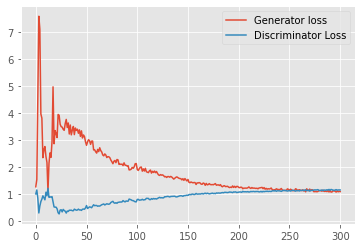

In [13]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"../outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
    
print('DONE TRAINING')
torch.save(generator.state_dict(), '../outputs/generator.pth')

# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('../outputs/generator_images.gif', imgs)

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('../outputs/loss.png')

In [15]:
generated_img = generator(noise).cpu().detach()
# make the images as grid
generated_img = make_grid(generated_img)
# save the generated torch tensor models to disk
save_generator_image(generated_img, f"../outputs/gen_img_test.png")